# Artificial Neural Networks and Deep Learning

---

## ⚓ Homework 2: Annechini, Fiorentini, Vignoli


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/Colab Notebooks/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/Homework 2


## ⚙️ Import Libraries

In [ ]:
# Import necessary libraries
import os
import logging
import random
from datetime import datetime
from io import BytesIO

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from PIL import Image

# Install and import keras-cv
!pip install keras-cv
!pip install --upgrade torchvision
import keras_cv

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Set environment variables
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = '42'
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Set seeds for reproducibility
seed = 41
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print versions and GPU devices
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ✴ Parameters definition

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

# Number of classes
NUM_CLASSES = 5

## ⏳ Load and process the Data

In [ ]:
data = np.load("mars_for_students.npz")
training_val_set = data["training_set"]
X_train_val = training_val_set[:, 0]
y_train_val = training_val_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train_val.shape}")
print(f"Training y shape: {y_train_val.shape}")
print(f"Test X shape: {X_test.shape}")

# Add color channel and rescale pixels between 0 and 1
X_train_val = X_train_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
y_train_val = y_train_val.astype(np.int32)

input_shape = X_train_val.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print("Training X dtype: ", X_train_val.dtype)
print("Training y dtype: ", y_train_val.dtype)
print("Test X dtype: ", X_test.dtype)

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)
Input shape: (64, 128, 1)
Number of classes: 5
Training X dtype:  float64
Training y dtype:  int32
Test X dtype:  float64


In [ ]:
# Outliers removing
reference_idx = 747
reference_mask = y_train_val[reference_idx]

indices_to_remove = [i for i in range(len(y_train_val)) if np.array_equal(y_train_val[i], reference_mask)]

X_train_filtered = np.delete(X_train_val, indices_to_remove, axis=0)
y_train_filtered = np.delete(y_train_val, indices_to_remove, axis=0)

print(f"Original data: {len(X_train_val)}")
print(f"Removed data: {len(indices_to_remove)}")
print(f"Filtered data: {len(X_train_filtered)}")
X_train_val = X_train_filtered
y_train_val = y_train_filtered
del X_train_filtered, y_train_filtered

Original data: 2615
Removed data: 110
Filtered data: 2505


In [ ]:
# Split the data
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
          random_state=seed, test_size=SPLITS_SIZE)
print("Data splitted!")

print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")
np.savez("Mars.npz", X_train=X_train, y_train=y_train, X_test=X_test,
         X_val=X_val, y_val=y_val)
del X_train_val, y_train_val
#del X_train, y_train, X_val, y_val, X_test

Splitting data...
Data splitted!
Train: (2004, 64, 128, 1)
Validation: (501, 64, 128, 1)
Test: (10022, 64, 128, 1)


## 🐯 Image Enlargment

In [ ]:
X_train = np.load("Mars.npz")["X_train"]
y_train = np.load("Mars.npz")["y_train"]

In [ ]:
X_train_big = np.concatenate([X_train] * 4, axis=0)
y_train_big = np.concatenate([y_train] * 4, axis=0)
print(X_train_big.shape)
print(y_train_big.shape)

(8016, 64, 128, 1)
(8016, 64, 128)


In [ ]:
augmentation = tf.keras.Sequential([
    keras_cv.layers.RandomContrast(value_range = [0, 1], factor = 0.2, seed=seed),
    keras_cv.layers.RandomBrightness(value_range = [0, 1], factor = 0.2, seed=seed)
])
X_train_big = augmentation(X_train_big)
print(tf.reduce_min(X_train_big).numpy(), tf.reduce_max(X_train_big).numpy())

0.0 1.0


In [ ]:
X_test = np.load("Mars.npz")["X_test"]
X_val = np.load("Mars.npz")["X_val"]
y_val = np.load("Mars.npz")["y_val"]

np.savez("Mars_big.npz",
         X_train=X_train_big,
         y_train=y_train_big,
         X_test=X_test,
         X_val=X_val,
         y_val=y_val)
del X_train_big, y_train_big
del X_val, y_val

## ⛽ Creation of Datasets

In [ ]:
data = np.load("Mars_big.npz")
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")

Train: (8016, 64, 128, 1)
Validation: (501, 64, 128, 1)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomTranslation(0.1, 0.1)
], name="data_augmentation")

def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset from existing data.
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:
        def augment_fn(x, y):
            x = tf.cast(x, tf.float32)
            y = tf.expand_dims(tf.cast(y, tf.float32), axis=-1)
            concatenated = tf.concat([x, y], axis=-1)
            augmented_concatenated = data_augmentation(concatenated)
            augmented_x = augmented_concatenated[..., :-1]
            augmented_y = tf.squeeze(augmented_concatenated[..., -1:], axis = -1)

            return tf.cast(augmented_x, tf.float64), tf.cast(augmented_y, tf.int32)

            dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

del X_train, X_val
del y_train, y_val

Creating datasets...
Datasets created!


In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label, ensuring same color for same class.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset (real images and ground truth).
    """
    plt.figure(figsize=(8, 2*num_samples))  # Increased the figure size for larger images

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        # Set number of rows and columns to plot two pairs per row
        for j in range(min(num_samples, len(images))):
            # Plot original image (in grayscale)
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

Visualizing examples from the training set:


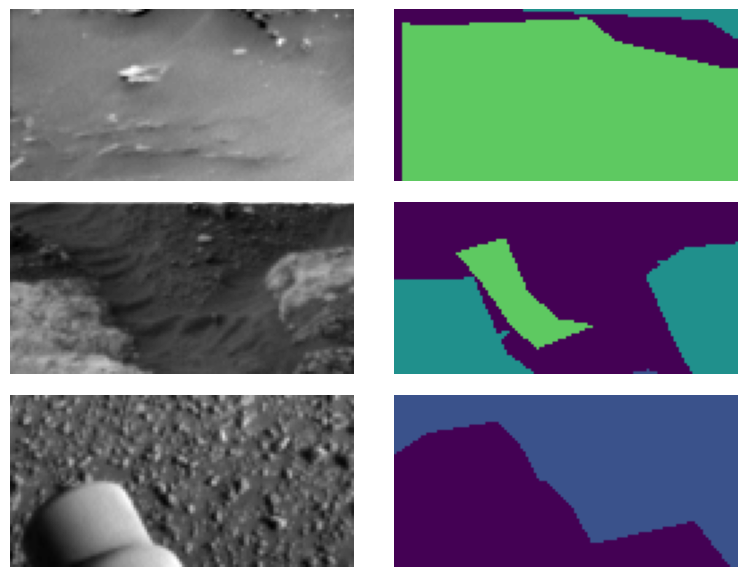

In [ ]:
# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

Visualizing examples from the validation set:


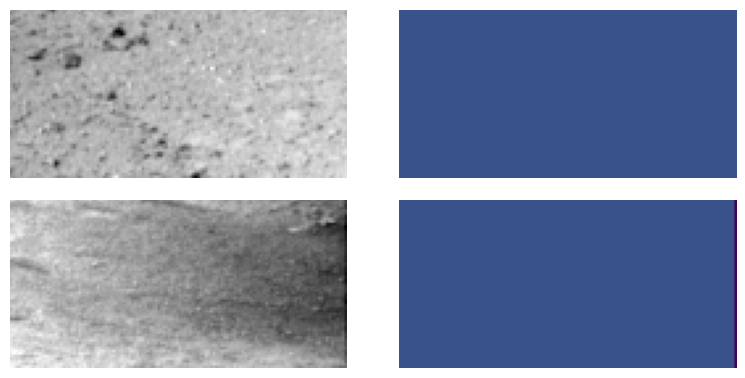

In [ ]:
# Visualize examples from the validation set
print("Visualizing examples from the validation set:")
plot_sample_batch(val_dataset, num_samples=2)

## 🚤 Layers and Model

In [ ]:
def inception_block(x, filters, kernel_size=3, padding='same', activation='relu', stack=1, name=''):
    for s in range(stack):
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        conv1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(conv1)
        conv1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(conv1)
        conv1 = tfkl.Dropout(0.4, name = name + "_dropout1")(conv1)

        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(x)
        conv3 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(conv3)
        conv3 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(conv3)
        conv3 = tfkl.Dropout(0.4, name = name + "_dropout2")(conv3)

        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(x)
        conv5 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(conv5)
        conv5 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(conv5)
        conv5 = tfkl.Dropout(0.4, name = name + "_dropout3" )(conv5)

        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding)(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(pool)
        pool_proj = tfkl.BatchNormalization(name=f'{name}_pool_bn_{s}')(pool_proj)
        pool_proj = tfkl.Activation(activation, name=f'{name}_pool_act_{s}')(pool_proj)
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([conv1, conv3, conv5, pool_proj])
        x = tfkl.Dropout(0.4, name=name + "_dropout4")(x)
    return x

def residual_block(x, filters, kernel_size=3, padding='same', activation='relu', stack=1, name=''):
    for s in range(stack):
        skip = x
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)
        x = tfkl.Dropout(0.4, name = name + "_dropout1")(x)
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)

        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)
        x = tfkl.Dropout(0.4, name=name + "_dropout2")(x)
    return x

In [ ]:
@tfk.utils.register_keras_serializable()
class PolarizedSelfAttention(tfkl.Layer):
    def __init__(self, name="psa", **kwargs):
        super().__init__(name=name, **kwargs)
        self.channel_conv = None
        self.spatial_conv = tfkl.Conv2D(1, (3, 3), padding="same", activation="sigmoid", name=f"{name}_spatial_conv")

    def build(self, input_shape):
        # Dynamically set the number of filters for channel_conv based on the input tensor
        filters = input_shape[-1]
        self.channel_conv = tfkl.Conv2D(filters, (1, 1), activation="sigmoid", name=f"{self.name}_channel_conv")
        super().build(input_shape)

    def call(self, input_tensor):
        # Channel Attention
        channel_attention = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
        channel_attention = self.channel_conv(channel_attention)
        channel_scaled = tf.multiply(input_tensor, channel_attention)

        # Spatial Attention
        spatial_attention = tf.reduce_mean(channel_scaled, axis=-1, keepdims=True)
        spatial_attention = self.spatial_conv(spatial_attention)
        spatial_scaled = tf.multiply(channel_scaled, spatial_attention)

        return spatial_scaled

In [ ]:
# Module Mini-ASPP
def mini_aspp(input_tensor, filters, name="aspp"):
    dilation_rates = [1, 6, 12, 18]
    outputs = []
    for i, rate in enumerate(dilation_rates):
        x = tfkl.Conv2D(filters, (3, 3), padding="same", dilation_rate=rate, name=f"{name}_dilated_{i}")(input_tensor)
        x = tfkl.BatchNormalization(name=f"{name}_bn_{i}")(x)
        x = tfkl.Activation("swish", name=f"{name}_relu_{i}")(x)
        outputs.append(x)
    return tfkl.Concatenate(name=f"{name}_concat")(outputs)

# Strip-pyramid pooling
def strip_pyramid_pooling(input_tensor, filters, name="spp"):
    strip_shapes = [(1, 3), (3, 1), (1, 5), (5, 1)]
    outputs = []
    for i, shape in enumerate(strip_shapes):
        x = tfkl.Conv2D(filters, shape, padding="same", name=f"{name}_strip_{i}")(input_tensor)
        x = tfkl.BatchNormalization(name=f"{name}_bn_{i}")(x)
        x = tfkl.Activation("swish", name=f"{name}_relu_{i}")(x)
        outputs.append(x)
    return tfkl.Concatenate(name=f"{name}_concat")(outputs)

In [ ]:
def get_marsseg_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    # Set random seed for reproducibility
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    BASE = 24

    # Downsampling path
    down_block_1 = residual_block(input_layer, BASE, name='down_block1_')
    d1 = tfkl.Conv2D(BASE * 2, kernel_size=3, strides=2, padding='same', name='downsample1')(down_block_1)
    down_block_2 = inception_block(d1, BASE * 2, activation='swish', name='down_block2_')
    d2 = tfkl.Conv2D(BASE * 4, kernel_size=3, strides=2, padding='same', name='downsample2')(down_block_2)
    down_block_3 = residual_block(d2, BASE * 4, activation='swish', name='down_block3_')
    d3 = tfkl.Conv2D(BASE * 8, kernel_size=3, strides=2, padding='same', name='downsample3')(down_block_3)

    # Bottleneck
    aspp = mini_aspp(d3, BASE * 8, name="aspp")
    bottleneck_attention = PolarizedSelfAttention(name="psa")(aspp)
    bottleneck_spp = strip_pyramid_pooling(bottleneck_attention, BASE * 8, name="spp")
    bottleneck = tfkl.Concatenate(name="bottleneck_concat")([bottleneck_attention, bottleneck_spp])

    # Upsampling path
    u1 = tfkl.Conv2DTranspose(BASE * 4, kernel_size=3, strides=2, padding='same', name="upsample1")(bottleneck)
    u1 = tfkl.BatchNormalization(name="up_norm1")(u1)
    u1 = residual_block(u1, BASE * 4, activation='swish', name='up_block1_')
    u1 = tfkl.Add(name="up_add1")([u1, down_block_3])
    u1 = tfkl.Concatenate(name="up_concat1")([u1, down_block_3])

    u2 = tfkl.Conv2DTranspose(BASE * 2, kernel_size=3, strides=2, padding='same', name="upsample2")(u1)
    u2 = tfkl.BatchNormalization(name="up_norm2")(u2)
    u2 = inception_block(u2, BASE * 2, activation='swish', name='up_block2_')
    u2 = tfkl.Add(name="up_add2")([u2, down_block_2])
    u2 = tfkl.Concatenate(name="up_concat2")([u2, down_block_2])

    u3 = tfkl.Conv2DTranspose(BASE, kernel_size=3, strides=2, padding='same', name="upsample3")(u2)
    u3 = tfkl.BatchNormalization(name="up_norm3")(u3)
    u3 = residual_block(u3, BASE, activation='swish', name='up_block3_')
    u3 = tfkl.Add(name="up_add3")([u3, down_block_1])
    u3 = tfkl.Concatenate(name="up_concat3")([u3, down_block_1])

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same',
                               activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='MarsSegModel')
    return model

Model: "MarsSegModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__conv1_0   │ (None, 64, 128, 24)  │          240 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__bn1_0     │ (None, 64, 128, 24)  │           96 │ down_block1__conv1… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__act1_0    │ (None, 64, 128, 24)  │            0 │ down_block1__bn1_0… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__dropout1  │ (None, 64, 128, 24)  │            0 │ down_block1__act1_… │    -    │
│ (Dropout)              │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__conv2_0   │ (None, 64, 128, 24)  │        5,208 │ down_block1__dropo… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__proj_0    │ (None, 64, 128, 24)  │           48 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__bn2_0     │ (None, 64, 128, 24)  │           96 │ down_block1__conv2… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__proj_bn_0 │ (None, 64, 128, 24)  │           96 │ down_block1__proj_… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__add_0     │ (None, 64, 128, 24)  │            0 │ down_block1__bn2_0… │    -    │
│ (Add)                  │                      │              │ down_block1__proj_… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__act2_0    │ (None, 64, 128, 24)  │            0 │ down_block1__add_0… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1__dropout2  │ (None, 64, 128, 24)  │            0 │ down_block1__act2_… │    -    │
│ (Dropout)              │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ downsample1 (Conv2D)   │ (None, 32, 64, 48)   │       10,416 │ down_block1__dropo… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2__conv1_0 

 Total params: 6,326,655 (24.13 MB)

 Trainable params: 6,322,047 (24.12 MB)

 Non-trainable params: 4,608 (18.00 KB)

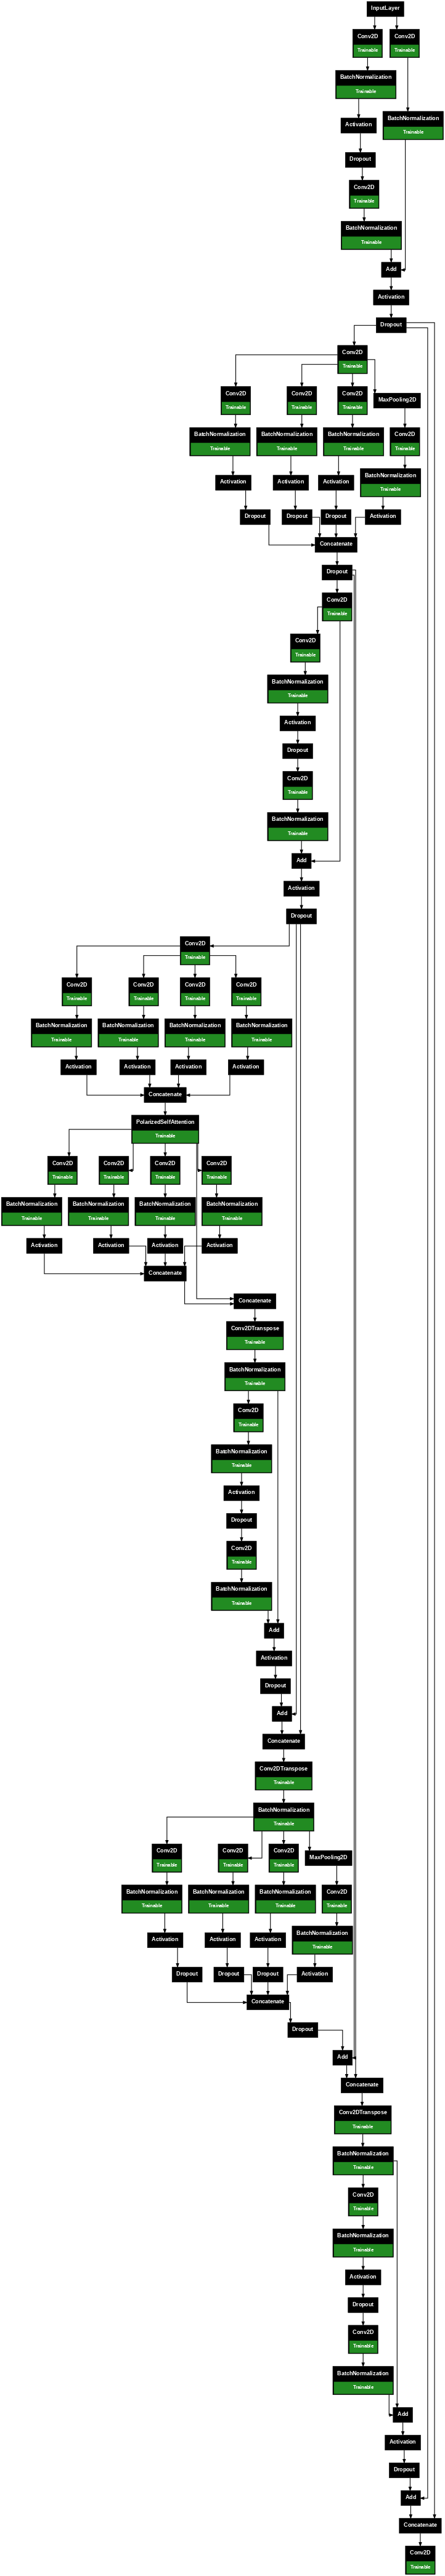

In [ ]:
model = get_marsseg_model()
model.summary(expand_nested=True, show_trainable=True)
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=40)

## 🔨 Metric and weights

In [ ]:
# Define custom Mean Intersection Over Union metric (IoU)
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, frequency=20):
        super().__init__()
        for images, labels in dataset.take(1):
            index = 10
            self.image = images[index]
            self.label = labels[index]
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            image, label = self.image, self.label
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0, :, :, 0], cmap="gray")  # Assuming single-channel input
            plt.title("Input Image")
            plt.axis("off")

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
def calculate_class_weights_segmentation(dataset, num_classes):
    class_counts = tf.zeros(num_classes, dtype=tf.float32)
    for _, labels in dataset:
        labels = tf.reshape(labels, [-1])  # Flatten all pixels
        unique, _, counts = tf.unique_with_counts(labels)  # Extract the correct outputs
        class_counts = tf.tensor_scatter_nd_add(class_counts, tf.reshape(unique, [-1, 1]), tf.cast(counts, tf.float32))
    total = tf.reduce_sum(class_counts)
    class_weights = total / (class_counts + 1e-6)
    class_weights /= tf.reduce_sum(class_weights)  # Normalize weights
    return class_weights
class_weights = calculate_class_weights_segmentation(train_dataset, NUM_CLASSES)
print(class_weights)

tf.Tensor([0.00602696 0.0042729  0.0066724  0.00783373 0.97519404], shape=(5,), dtype=float32)


## 🎯 Loss function

In [ ]:
@tf.keras.utils.register_keras_serializable()
def improved_combined_loss(y_true, y_pred, class_weights):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)
    adjusted_class_weights = tf.constant([0.01 if i == 0 else 1.0 for i in range(NUM_CLASSES)], dtype=tf.float32)
    combined_weights = adjusted_class_weights * class_weights
    weights = tf.reduce_sum(combined_weights * y_true_one_hot, axis=-1, keepdims=True)

    def margin_map_loss(y_true_one_hot, y_pred, smooth=1e-6):
        y_pred = tf.math.softmax(y_pred)

        exponent = 5

        # FALSE NEGATIVE LOSS
        margin_loss = 1 + (
            tf.norm(tf.multiply(1 - y_true_one_hot, y_pred), axis=-1, ord=exponent)
            - tf.norm(tf.multiply(y_true_one_hot, y_pred), axis=-1)
        )
        weight_coeffs = tf.norm(tf.multiply(y_true_one_hot, weights), axis=-1)
        batch_size = tf.shape(y_pred)[0]
        denominator = tf.reduce_sum(weight_coeffs) / tf.cast((batch_size * y_pred.shape[1] * y_pred.shape[2]), "float32")
        weight_coeffs = weight_coeffs / denominator
        fn_loss = tf.reduce_mean(margin_loss * weight_coeffs)

        # FALSE POSITIVE LOSS
        y_pred_modified = tf.pow(y_pred, exponent)
        y_pred_modified = y_pred_modified / (tf.reduce_sum(y_pred_modified, axis=-1, keepdims=True) + (0.2 ** exponent) * smooth)
        y_pred_modified = y_pred_modified * (1 - y_true_one_hot)

        fp_weight_coeffs = tf.reduce_sum(combined_weights * y_pred_modified, axis=-1, keepdims=True)
        fp_loss = tf.reduce_mean(fp_weight_coeffs / denominator)

        return 0.99 * fn_loss + 0.01 * fp_loss

    def weighted_dice_loss(y_true_one_hot, y_pred, smooth=1e-6):
        y_pred = tf.math.softmax(y_pred)
        intersection = tf.reduce_sum(weights * y_true_one_hot * y_pred, axis=[1, 2, 3])
        denominator = tf.reduce_sum(weights * (y_true_one_hot + y_pred), axis=[1, 2, 3])
        return 1 - tf.reduce_mean((2 * intersection + smooth) / (denominator + smooth))

    def improved_focal_loss(y_true_one_hot, y_pred, gamma=2.0, alpha=0.25):
        y_pred = tf.math.softmax(y_pred)
        pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        focal = -alpha * (1 - pt) ** gamma * tf.math.log(tf.clip_by_value(pt, 1e-6, 1.0))
        reduced_weights = tf.squeeze(weights, axis=-1)
        return tf.reduce_mean(reduced_weights * focal)

    def iou_loss(y_true_one_hot, y_pred, smooth=1e-6):
        y_pred = tf.math.softmax(y_pred)
        intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true_one_hot + y_pred, axis=[1, 2, 3]) - intersection
        return 1 - tf.reduce_mean((intersection + smooth) / (union + smooth))

    dice = weighted_dice_loss(y_true_one_hot, y_pred)
    focal = improved_focal_loss(y_true_one_hot, y_pred)
    iou = iou_loss(y_true_one_hot, y_pred)

    total_loss = 2*focal + 2*dice + 1*iou

    return 2 * margin_map_loss(y_true_one_hot, y_pred) + 1 * total_loss

## 🎹 Train the Model

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=lambda y_true, y_pred: improved_combined_loss(y_true, y_pred, class_weights),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(val_dataset)

# Learning rate
LROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    factor=0.75,
    patience=PATIENCE//7,
    verbose=1,
    min_lr = 1e-7
)

Epoch 1/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 4.9243 - mean_iou: 0.1014

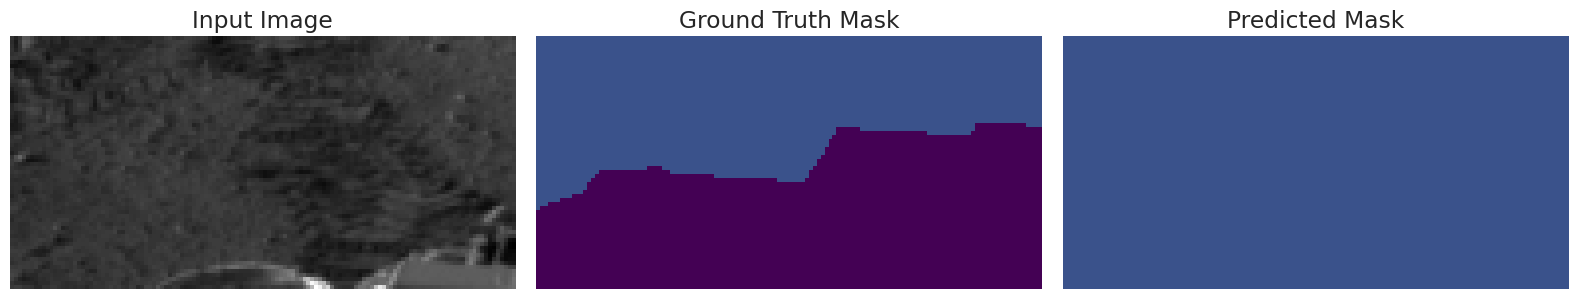

126/126 ━━━━━━━━━━━━━━━━━━━━ 105s 458ms/step - loss: 4.9229 - mean_iou: 0.1016 - val_loss: 4.6545 - val_mean_iou: 0.1034 - learning_rate: 0.0010
Epoch 2/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.5743 - mean_iou: 0.1620 - val_loss: 4.5055 - val_mean_iou: 0.2139 - learning_rate: 0.0010
Epoch 3/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.3710 - mean_iou: 0.2505 - val_loss: 4.6538 - val_mean_iou: 0.1034 - learning_rate: 0.0010
Epoch 4/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4.2742 - mean_iou: 0.2871 - val_loss: 4.6538 - val_mean_iou: 0.1034 - learning_rate: 0.0010
Epoch 5/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.1981 - mean_iou: 0.3278 - val_loss: 4.6538 - val_mean_iou: 0.1034 - learning_rate: 0.0010
Epoch 6/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.1807 - mean_iou: 0.3383 - val_loss: 4.2313 - val_mean_iou: 0.2943 - learning_rate: 0.0010
Epoch 7/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.1334 - mean_iou

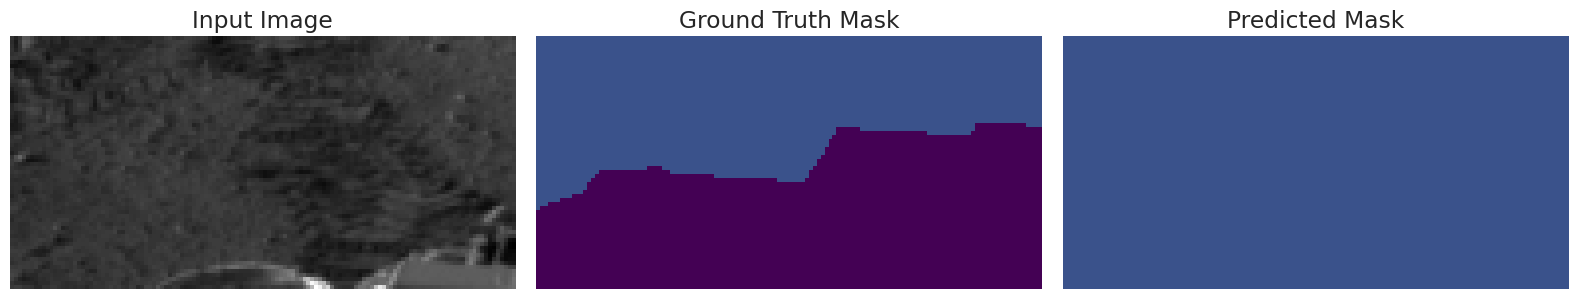

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 3.9287 - mean_iou: 0.4856 - val_loss: 3.9883 - val_mean_iou: 0.5146 - learning_rate: 5.6250e-04
Epoch 22/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.9191 - mean_iou: 0.4946
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0004218749818392098.
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.9191 - mean_iou: 0.4946 - val_loss: 3.9748 - val_mean_iou: 0.5114 - learning_rate: 5.6250e-04
Epoch 23/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.9015 - mean_iou: 0.5167 - val_loss: 3.9559 - val_mean_iou: 0.5387 - learning_rate: 4.2187e-04
Epoch 24/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.8904 - mean_iou: 0.5268 - val_loss: 3.9262 - val_mean_iou: 0.5576 - learning_rate: 4.2187e-04
Epoch 25/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 3.8896 - mean_iou: 0.5297 - val_loss: 3.9402 - val_mean_iou: 0.5501 - learning_rate: 4.2187e-04
Epoch 26/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - los

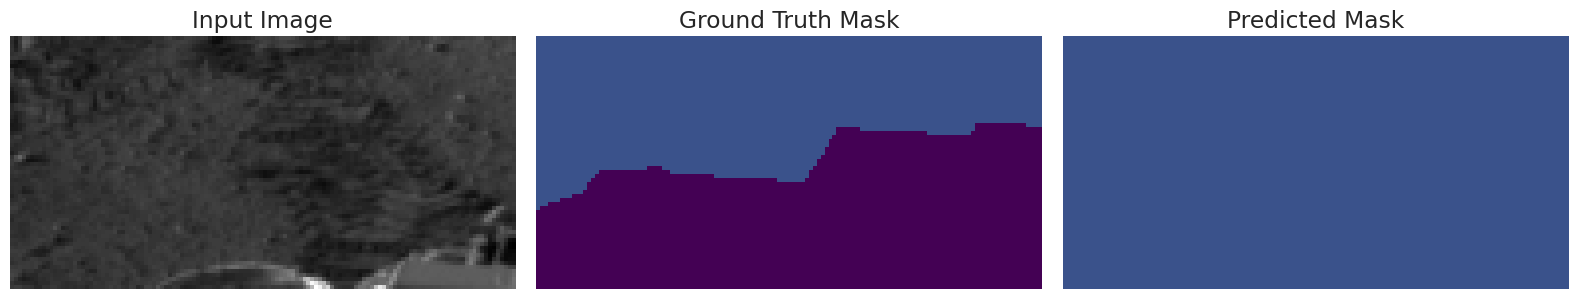

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 3.8076 - mean_iou: 0.6144 - val_loss: 3.9107 - val_mean_iou: 0.5718 - learning_rate: 2.3730e-04
Epoch 42/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.8042 - mean_iou: 0.6150 - val_loss: 3.9565 - val_mean_iou: 0.5364 - learning_rate: 2.3730e-04
Epoch 43/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.8000 - mean_iou: 0.6184
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.00017797851614886895.
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.8001 - mean_iou: 0.6182 - val_loss: 3.9289 - val_mean_iou: 0.5578 - learning_rate: 2.3730e-04
Epoch 44/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7908 - mean_iou: 0.6243 - val_loss: 3.8954 - val_mean_iou: 0.5769 - learning_rate: 1.7798e-04
Epoch 45/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 3.7934 - mean_iou: 0.6239 - val_loss: 3.9218 - val_mean_iou: 0.5648 - learning_rate: 1.7798e-04
Epoch 46/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - lo

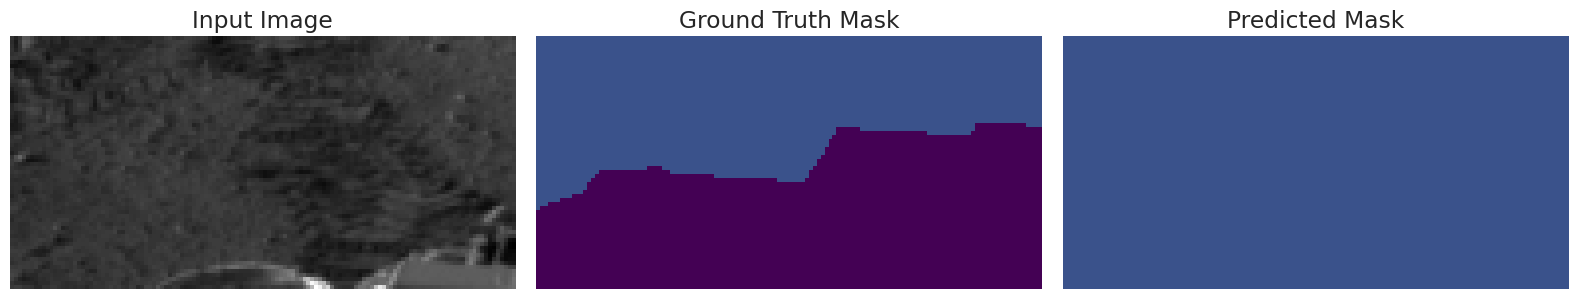

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 3.7605 - mean_iou: 0.6708 - val_loss: 3.9115 - val_mean_iou: 0.5730 - learning_rate: 1.0011e-04
Epoch 62/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7674 - mean_iou: 0.6668 - val_loss: 3.8924 - val_mean_iou: 0.5865 - learning_rate: 1.0011e-04
Epoch 63/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7649 - mean_iou: 0.6631 - val_loss: 3.8782 - val_mean_iou: 0.5940 - learning_rate: 1.0011e-04
Epoch 64/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.7710 - mean_iou: 0.6525
Epoch 64: ReduceLROnPlateau reducing learning rate to 7.508467933803331e-05.
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7710 - mean_iou: 0.6523 - val_loss: 3.8801 - val_mean_iou: 0.5966 - learning_rate: 1.0011e-04
Epoch 65/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7570 - mean_iou: 0.6644 - val_loss: 3.9008 - val_mean_iou: 0.5792 - learning_rate: 7.5085e-05
Epoch 66/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - los

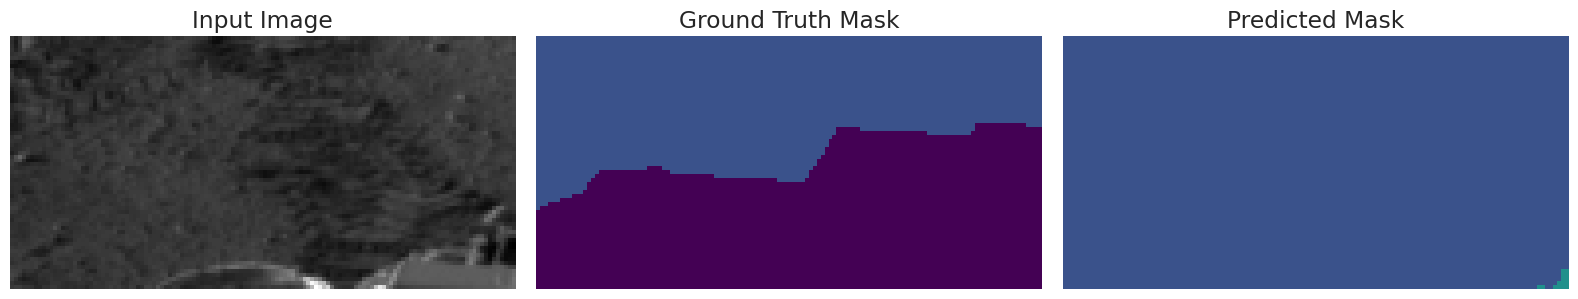

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 3.7514 - mean_iou: 0.6693 - val_loss: 3.8872 - val_mean_iou: 0.5906 - learning_rate: 4.2235e-05
Epoch 82/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7500 - mean_iou: 0.6679 - val_loss: 3.8836 - val_mean_iou: 0.5904 - learning_rate: 4.2235e-05
Epoch 83/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 3.7461 - mean_iou: 0.6746 - val_loss: 3.9018 - val_mean_iou: 0.5805 - learning_rate: 4.2235e-05
Epoch 84/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7464 - mean_iou: 0.6757 - val_loss: 3.8775 - val_mean_iou: 0.5972 - learning_rate: 4.2235e-05
Epoch 85/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.7462 - mean_iou: 0.6969
Epoch 85: ReduceLROnPlateau reducing learning rate to 3.167634986311896e-05.
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7463 - mean_iou: 0.6963 - val_loss: 3.8963 - val_mean_iou: 0.5829 - learning_rate: 4.2235e-05
Epoch 86/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - los

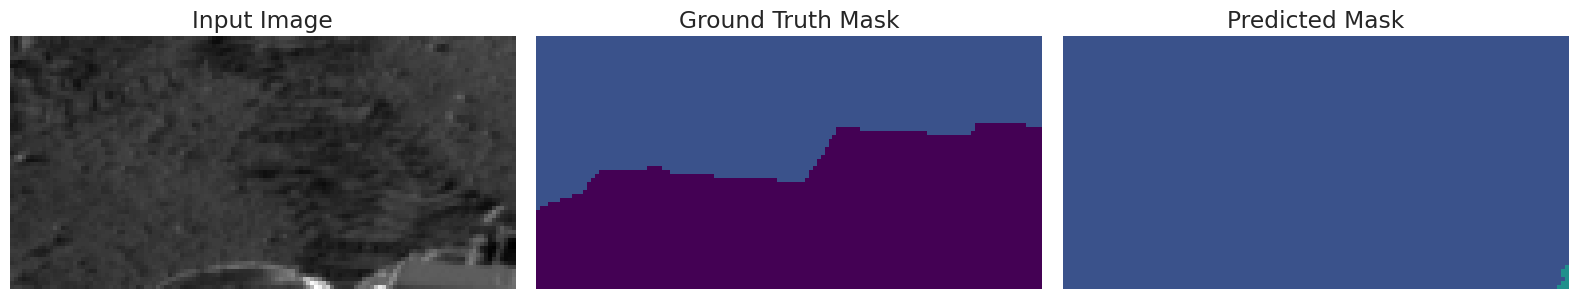

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 3.7399 - mean_iou: 0.6794 - val_loss: 3.8722 - val_mean_iou: 0.6003 - learning_rate: 1.7818e-05
Epoch 102/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 3.7465 - mean_iou: 0.7888 - val_loss: 3.8882 - val_mean_iou: 0.5895 - learning_rate: 1.7818e-05
Epoch 103/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7377 - mean_iou: 0.7017 - val_loss: 3.8709 - val_mean_iou: 0.6017 - learning_rate: 1.7818e-05
Epoch 104/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7388 - mean_iou: 0.7148 - val_loss: 3.8811 - val_mean_iou: 0.5938 - learning_rate: 1.7818e-05
Epoch 105/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7386 - mean_iou: 0.7422 - val_loss: 3.8891 - val_mean_iou: 0.5874 - learning_rate: 1.7818e-05
Epoch 106/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.7383 - mean_iou: 0.6980
Epoch 106: ReduceLROnPlateau reducing learning rate to 1.3363460311666131e-05.
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/ste

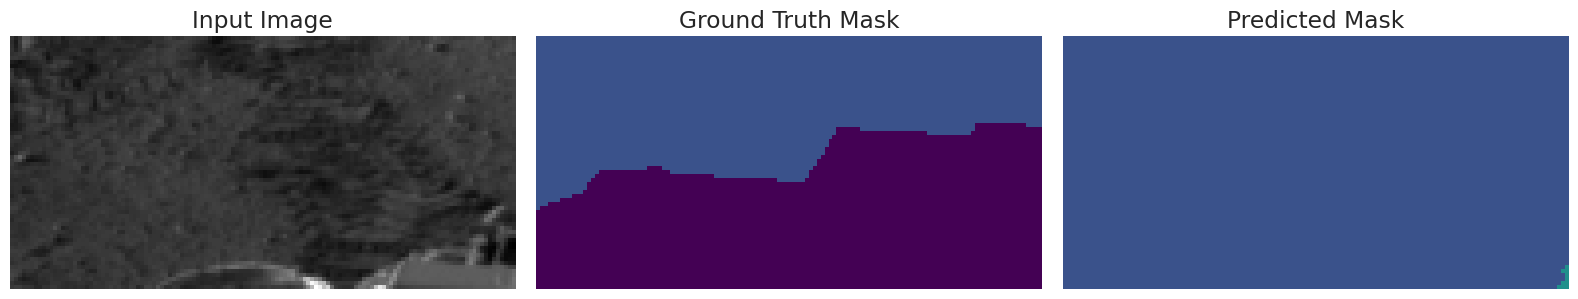

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 3.7324 - mean_iou: 0.6840 - val_loss: 3.8785 - val_mean_iou: 0.5969 - learning_rate: 7.5169e-06
Epoch 122/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 3.7364 - mean_iou: 0.8419 - val_loss: 3.8786 - val_mean_iou: 0.5964 - learning_rate: 7.5169e-06
Epoch 123/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7344 - mean_iou: 0.7325 - val_loss: 3.8790 - val_mean_iou: 0.5964 - learning_rate: 7.5169e-06
Epoch 124/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 3.7346 - mean_iou: 0.7038 - val_loss: 3.8822 - val_mean_iou: 0.5942 - learning_rate: 7.5169e-06
Epoch 125/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7356 - mean_iou: 0.6811 - val_loss: 3.8792 - val_mean_iou: 0.5960 - learning_rate: 7.5169e-06
Epoch 126/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 3.7337 - mean_iou: 0.7160 - val_loss: 3.8796 - val_mean_iou: 0.5958 - learning_rate: 7.5169e-06
Epoch 127/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 35

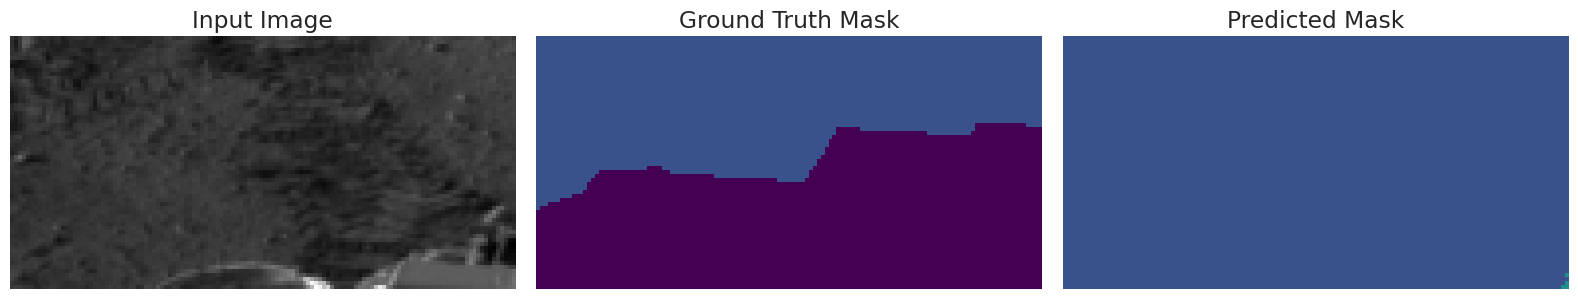

126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 3.7423 - mean_iou: 0.7430 - val_loss: 3.8771 - val_mean_iou: 0.5975 - learning_rate: 4.2283e-06
Epoch 142/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7297 - mean_iou: 0.6816 - val_loss: 3.8800 - val_mean_iou: 0.5955 - learning_rate: 3.1712e-06
Epoch 143/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7305 - mean_iou: 0.7043 - val_loss: 3.8790 - val_mean_iou: 0.5962 - learning_rate: 3.1712e-06
Epoch 144/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7362 - mean_iou: 0.6873 - val_loss: 3.8808 - val_mean_iou: 0.5945 - learning_rate: 3.1712e-06
Epoch 145/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 3.7336 - mean_iou: 0.8492 - val_loss: 3.8825 - val_mean_iou: 0.5935 - learning_rate: 3.1712e-06
Epoch 146/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.7356 - mean_iou: 0.7970 - val_loss: 3.8840 - val_mean_iou: 0.5923 - learning_rate: 3.1712e-06
Epoch 147/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, LROnPlateau, viz_callback],
    shuffle=True,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_MARSS.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

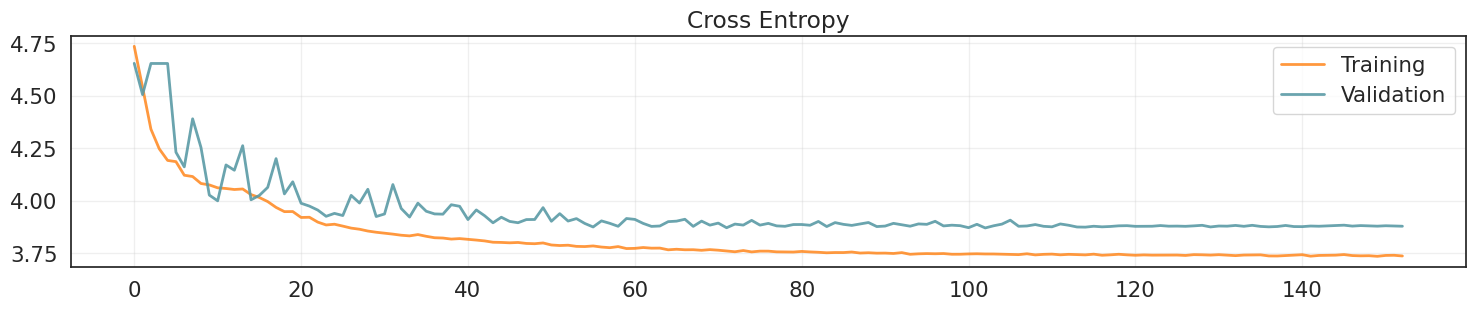

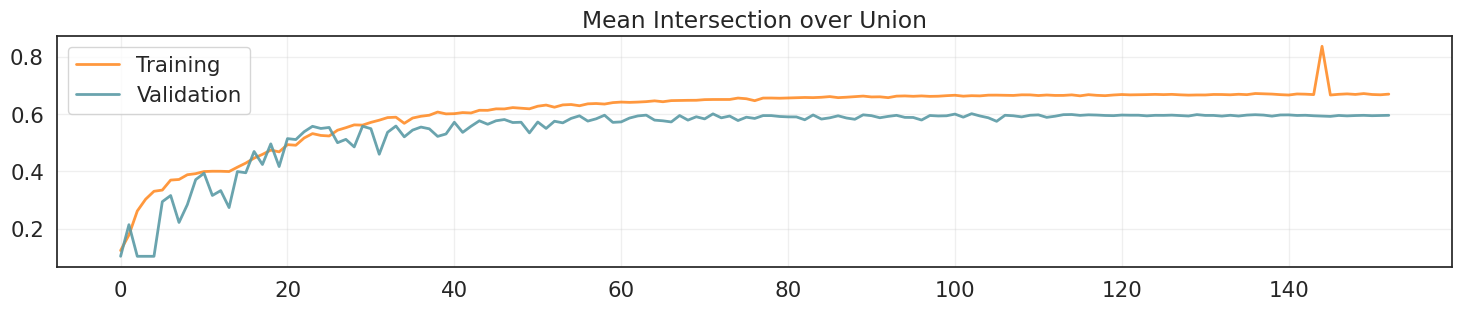

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
model_filename = "UNet_MARSS.keras"
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_MARSS.keras


In [ ]:
X_test = np.load("Mars.npz")["X_test"]
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


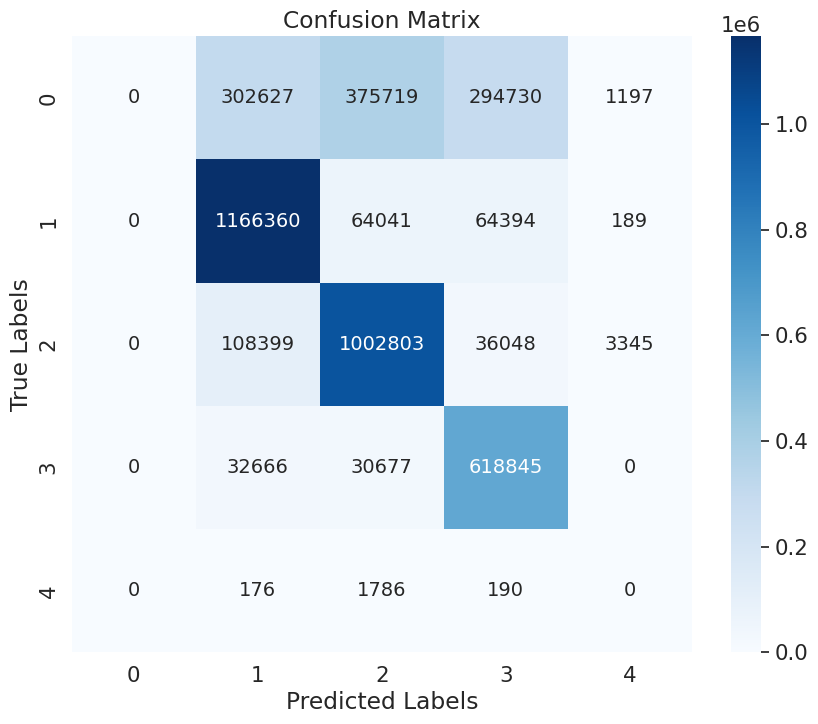

In [ ]:
# prompt: compute validation predictions and plot comfusion matrix. use the val_dataset variable

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming val_dataset is defined and provides (images, labels)
y_true = []
y_pred = []

for images, labels in val_dataset:
  preds = new_model.predict(images)
  preds = np.argmax(preds, axis=-1)
  y_true.extend(labels.numpy().flatten())
  y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prompt: write a script that loads the UNet_MARSS.keras and substitutes the output layer's activation from "softmax" to "linear". The y_pred should be the same since softmax does not change the max entry

import tensorflow as tf
from tensorflow import keras as tfk

# Load the model
model_filename = "UNet_MARSS.keras"
model = tfk.models.load_model(model_filename, compile=False)

# Get the output layer
output_layer = model.layers[-1]

# Create a new output layer with linear activation
new_output_layer = tfk.layers.Conv2D(
    filters=output_layer.filters,
    kernel_size=output_layer.kernel_size,
    padding=output_layer.padding,
    activation="linear",  # Correct activation
    name="new_output_layer"
)

# Set the weights and biases from the original output layer
new_output_layer.build(output_layer.input.shape)
new_output_layer.set_weights(output_layer.get_weights())

# Create a new model with the modified output layer
new_model = tfk.Model(inputs=model.input, outputs=new_output_layer(model.layers[-2].output))

# The following code is to verify that the maximum entry remains the same
# after changing the activation function
#X_test = np.load("Mars.npz")["X_test"]
original_preds = model.predict(val_dataset)
new_preds = new_model.predict(val_dataset)

# Check if the index of the maximum value is the same
print("Indices of maximum values are the same:",
      np.all(np.argmax(original_preds, axis=-1) == np.argmax(new_preds, axis=-1)))

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step
Indices of maximum values are the same: True


In [ ]:
# Predict on the validation set
y_pred = new_model.predict(val_dataset)

# Extract predictions for the last class (class 4, assuming 0-based indexing)
class_4_predictions = []
for batch in y_pred:
    for image_predictions in batch:
        class_4_predictions.extend(image_predictions[..., 2].flatten())  # Access class 4 predictions

class_4_predictions = np.array(class_4_predictions)

# Compute the minimum and maximum values
min_val = np.min(class_4_predictions)
max_val = np.max(class_4_predictions)

print(f"Minimum value for class 4 in validation predictions: {min_val}")
print(f"Maximum value for class 4 in validation predictions: {max_val}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Minimum value for class 4 in validation predictions: -87.18595123291016
Maximum value for class 4 in validation predictions: 54.057891845703125


In [ ]:
# prompt: modify classify_predictions so that class 4 is now class 1

def classify_predictions(predictions, val_class, threshold):
    """
    Classifies predictions based on a threshold and maximum of other classes.

    Args:
      predictions: A NumPy array of shape (None, 64, 128, 5) representing the logits.
      threshold: The threshold value for classifying as class 4.

    Returns:
      A NumPy array of the same shape as predictions, with classifications.
    """

    # Convert predictions to probabilities using softmax
    probabilities = predictions # tf.nn.softmax(predictions, axis=-1)

    # Identify samples above the threshold for class 4
    class_4_mask = probabilities[..., val_class] > threshold

    # Create an array to store the classifications
    classifications = tf.zeros_like(probabilities[..., val_class], dtype=tf.int64) # Change dtype to tf.int64

    # Classify samples above the threshold as class 1 (instead of class 4)
    classifications = tf.where(class_4_mask, val_class, classifications)

    # For samples below the threshold, find the class with the maximum probability (excluding class 4)
    other_classes_probs = probabilities # probabilities[..., :4]
    max_other_classes = tf.argmax(other_classes_probs, axis=-1)

    # Combine classifications, ensuring both inputs have the same dtype
    classifications = tf.where(tf.equal(classifications,0), tf.cast(max_other_classes, tf.int64), classifications) # Cast max_other_classes to tf.int64

    # One-hot encode the classifications
    classifications_one_hot = tf.one_hot(classifications, depth=5)

    return classifications_one_hot

In [ ]:
# prompt: create a new classify_predictions function so that, if the entry is lower than the threshold, the one_hot_encoded result contains all zeroes

def classify_predictions_mod(predictions, val_class, threshold):
    """
    Classifies predictions based on a threshold and maximum of other classes.

    Args:
      predictions: A NumPy array of shape (None, 64, 128, 5) representing the logits.
      threshold: The threshold value for classifying as class 4.

    Returns:
      A NumPy array of the same shape as predictions, with classifications.
    """

    # Convert predictions to probabilities using softmax
    probabilities = predictions #tf.nn.softmax(predictions, axis=-1)

    # Identify samples above the threshold for the specified class
    class_mask = probabilities[..., val_class] > threshold

    # Create an array to store the classifications
    classifications = tf.zeros_like(probabilities[..., val_class], dtype=tf.int64)

    # Classify samples above the threshold as the specified class
    classifications = tf.where(class_mask, val_class, classifications)

    # For samples below the threshold, create an all-zero one-hot encoding
    other_classes_probs = probabilities
    max_other_classes = tf.argmax(other_classes_probs, axis=-1)
    classifications = tf.where(tf.equal(classifications,0), tf.cast(max_other_classes, tf.int64), classifications)

    # One-hot encode the classifications
    classifications_one_hot = tf.one_hot(classifications, depth=5)

    #Set all zero if entry is below threshold
    zeros = tf.zeros_like(classifications_one_hot)
    classifications_one_hot = tf.where(tf.expand_dims(class_mask,-1), classifications_one_hot, zeros)

    return classifications_one_hot

In [ ]:
# prompt: write a function that finds the optimal threshold for class 4 in order to maximize the MeanIntersectionOverUnion excluding the background (0)

def find_optimal_threshold(y_true, y_pred, class_index=4):
    """
    Finds the optimal threshold for a specific class to maximize Mean Intersection over Union (mIoU).

    Args:
        y_true: Ground truth labels.
        y_pred: Predicted probabilities or logits.
        class_index: The index of the class for which to find the optimal threshold.

    Returns:
        The optimal threshold that maximizes mIoU for the specified class.
    """

    start = -50
    end = 50

    for i in range(5):
        print(f"Class {class_index} Round {i}")
        thresholds = np.linspace(start, end, 101)  # Create a range of thresholds
        best_mIoU = 0
        optimal_threshold = 0

        for threshold in thresholds:
            # Classify predictions based on the current threshold
            y_pred_thresholded = classify_predictions(y_pred, class_index, threshold)

            # Calculate mIoU, excluding the background (class 0)
            mIoU_metric = MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])(y_true, y_pred_thresholded)
            #mIoU_metric.update_state(y_true, y_pred_thresholded)
            current_mIoU = mIoU_metric # mIoU_metric.result().numpy()

            #print(threshold,current_mIoU)

            if current_mIoU > best_mIoU:
                best_mIoU = current_mIoU
                optimal_threshold = threshold

        new_range = (end-start)/50
        start = optimal_threshold - new_range
        end = optimal_threshold + new_range

    return optimal_threshold, best_mIoU

y_pred = new_model.predict(val_dataset)

y_true = []
for _, labels in val_dataset:
  y_true.extend(labels.numpy().flatten())
y_true = np.array(y_true)

for c in range(1,5):
# Example usage (assuming you have y_true and y_pred from your validation set)
    optimal_threshold, best_mIoU = find_optimal_threshold(y_true, y_pred, c)

    print(f"Optimal threshold for class {c}: {optimal_threshold}")
    print(f"Best mIoU for class {c}: {best_mIoU}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Class 1 Round 0
Class 1 Round 1
Class 1 Round 2
Class 1 Round 3
Class 1 Round 4
Optimal threshold for class 1: 7.75635968
Best mIoU for class 1: 0.6016889810562134
Class 2 Round 0
Class 2 Round 1
Class 2 Round 2
Class 2 Round 3
Class 2 Round 4
Optimal threshold for class 2: -0.5757209600000001
Best mIoU for class 2: 0.6042487621307373
Class 3 Round 0
Class 3 Round 1
Class 3 Round 2
Class 3 Round 3
Class 3 Round 4
Optimal threshold for class 3: 7.7485056
Best mIoU for class 3: 0.6016877293586731
Class 4 Round 0
Class 4 Round 1
Class 4 Round 2
Class 4 Round 3
Class 4 Round 4
Optimal threshold for class 4: 2.3343897600000005
Best mIoU for class 4: 0.6016914248466492


In [ ]:
preds = new_model.predict(val_dataset)
starting_preds = tf.nn.softmax(preds, axis=-1)

max_off = 20

starting_preds += classify_predictions_mod(preds,1,7.75635968)*(max_off*(max_off+1))/2
starting_preds += classify_predictions_mod(preds,2,-0.5757209600000001)*2*(max_off*(max_off+1))/2
starting_preds += classify_predictions_mod(preds,3,7.7485056)*2*(max_off*(max_off+1))/2
starting_preds += classify_predictions_mod(preds,4,2.3343897600000005)*(max_off*(max_off+1))/2

for offset in range(1,2*max_off):
    starting_preds += classify_predictions_mod(preds,1,7.75635968 - max_off/offset)*((max_off-offset)*(max_off-offset+1))/2
    starting_preds += classify_predictions_mod(preds,2,-0.5757209600000001 - max_off/offset)*2*((max_off-offset)*(max_off-offset+1))/2
    starting_preds += classify_predictions_mod(preds,3,7.7485056 - max_off/offset)*2*((max_off-offset)*(max_off-offset+1))/2
    starting_preds += classify_predictions_mod(preds,4,2.3343897600000005 - max_off/offset)*((max_off-offset)*(max_off-offset+1))/2
preds = starting_preds / tf.reduce_sum(starting_preds, axis=-1, keepdims=True)

y_true = []
for _, labels in val_dataset:
  y_true.extend(labels.numpy().flatten())
y_true = np.array(y_true)

mIoU_metric = MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])(y_true, preds)
print(f"Best mIoU: {mIoU_metric}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best mIoU: 0.6042106747627258


In [ ]:
X_test = np.load("Mars.npz")["X_test"]
preds = new_model.predict(X_test)
preds = classify_predictions(preds,2,-0.5757).numpy()
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Predictions shape: (10022, 64, 128)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
preds = new_model.predict(X_test)
starting_preds = tf.nn.softmax(preds, axis=-1)

starting_preds += classify_predictions_mod(preds,1,7.75635968)
starting_preds += classify_predictions_mod(preds,2,-0.5757209600000001)*2
starting_preds += classify_predictions_mod(preds,3,7.7485056)*2
starting_preds += classify_predictions_mod(preds,4,2.3343897600000005)

max_off = 10
for offset in range(1,max_off):
    starting_preds += classify_predictions_mod(preds,1,7.75635968 - max_off/offset)
    starting_preds += classify_predictions_mod(preds,2,-0.5757209600000001 - max_off/offset)*2
    starting_preds += classify_predictions_mod(preds,3,7.7485056 - max_off/offset)*2
    starting_preds += classify_predictions_mod(preds,4,2.3343897600000005 - max_off/offset)

preds = starting_preds / tf.reduce_sum(starting_preds, axis=-1, keepdims=True)

preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Predictions shape: (10022, 64, 128)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
preds = new_model.predict(X_test)
starting_preds = tf.nn.softmax(preds, axis=-1)

max_off = 20

starting_preds += classify_predictions_mod(preds,1,7.75635968)*(max_off*(max_off+1))/2
starting_preds += classify_predictions_mod(preds,2,-0.5757209600000001)*2*(max_off*(max_off+1))/2
starting_preds += classify_predictions_mod(preds,3,7.7485056)*2*(max_off*(max_off+1))/2
starting_preds += classify_predictions_mod(preds,4,2.3343897600000005)*(max_off*(max_off+1))/2

for offset in range(1,2*max_off):
    starting_preds += classify_predictions_mod(preds,1,7.75635968 - max_off/offset)*((max_off-offset)*(max_off-offset+1))/2
    starting_preds += classify_predictions_mod(preds,2,-0.5757209600000001 - max_off/offset)*2*((max_off-offset)*(max_off-offset+1))/2
    starting_preds += classify_predictions_mod(preds,3,7.7485056 - max_off/offset)*2*((max_off-offset)*(max_off-offset+1))/2
    starting_preds += classify_predictions_mod(preds,4,2.3343897600000005 - max_off/offset)*((max_off-offset)*(max_off-offset+1))/2
preds = starting_preds / tf.reduce_sum(starting_preds, axis=-1, keepdims=True)

preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)


314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Predictions shape: (10022, 64, 128)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```